In [1]:
import gdown

In [2]:
!gdown --id 1KmoZYmPzxrrtR4a3mSfPIumbDwf_Mrpw > /dev/null 2>&1
!gdown --id 19vK08esg9hQtD8JB-9jm7Qkck7nZ-ZqR > /dev/null 2>&1

## About the Dataset
This a YouTube comments dataset scrapped using the [YouTube Data API](https://developers.google.com/youtube/v3/docs/comments). Currently the dataset consists of roughly **1.12M** comments. The dataset can be accessed [here](https://drive.google.com/drive/folders/1-9OnYbFuiSA0M7skOYche5erzZ4Ba5Nz?usp=sharing).
<br><br>
The dataset currently has text in _English, Hindi and Hinglish_.
Please refer to the following information for an overview of the columns and the corresponding data stored within them. [Link](https://github.com/aatmanvaidya/Sentiment-Analysis-of-Online-Harassment-Towards-Women-Wrestlers/blob/scraper/attributes.txt).

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from collections import Counter
import re

In [4]:
%%time
df = pd.read_feather(r'comments_cleaned_feather.feather')

CPU times: user 2.23 s, sys: 1.06 s, total: 3.29 s
Wall time: 3.62 s


In [5]:
df.head()

,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,parentId,commentId
0,EBOKYsWUhvI,Dub maro jaato 😢😢.<br>Tumse tumare ladkiya nhi...,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,HECTOR OF TROY,https://yt3.ggpht.com/ytc/AOPolaQNP5bd7gNvbAas...,http://www.youtube.com/channel/UC5G8fjqoiFIqHp...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},True,none,0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,None,UgwbyvIkkAhUdaCFpcp4AaABAg
1,EBOKYsWUhvI,Haar gye bechare,Haar gye bechare,Geeta Saini,https://yt3.ggpht.com/8XmOPNrT3Vy3wr0fItlWbaMk...,http://www.youtube.com/channel/UCsMGRdH3YHrbs2...,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},True,none,0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,None,Ugyz3OwSXamho91-8I94AaABAg
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,Dhamki mili pahalwano ko aur sab manage kr liy...,Ayaan Chouhan,https://yt3.ggpht.com/ytc/AOPolaREH2WnrnbD53OI...,http://www.youtube.com/channel/UC_dWuNh6zydTHI...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},True,none,0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,None,Ugyphs1TT1Yoj7MZBVJ4AaABAg
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,Kamal,https://yt3.ggpht.com/ytc/AOPolaTRSm_dEOKj9H82...,http://www.youtube.com/channel/UCVdGObpHM-IMHB...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},True,none,1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,None,UgwnIxpuFAcKsEzffBp4AaABAg
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,Pahlwan jante h kuch nhi kr payenge uska,jagriti tiwari upp,https://yt3.ggpht.com/ytc/AOPolaRrFnzD2i3N_3rk...,http://www.youtube.com/channel/UCRkcewHFhxE5Kf...,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},True,none,0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,None,UgxjuOlDigsmuDu53J54AaABAg


In [6]:
df.shape

(1119948, 14)

## Data Cleaning
- removed `^M`
- `\u200b` char (because of devnagiri script)
- header rows appened multiple times
- publishedAt has time like 0,1,2 - remove all that
- convert text column to string

In [7]:
header = np.array(df.columns)
df = df[~np.all(df.values == header, axis=1)]
df = df[~df['videoId'].str.contains(r'\bvideoId\b', case=False, regex=True)]
pattern = r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z$'
df = df[df['publishedAt'].str.contains(pattern)]

In [8]:
df['textOriginal'] = df['textOriginal'].astype(str)

In [9]:
duplicate_rows = df[df.duplicated(subset='textOriginal', keep=False)]

In [15]:
len(df['textDisplay'].unique())

76258

In [11]:
# Now this is strange, the dataset doesnt have duplicate or empty rows, why is this happening? is it some datatype problem?
# Lets try to do a simple check for it again

In [12]:
%%time
count = 0
value_list = []
for index, row in df.iterrows():
    value_list.append(row['textOriginal'])
    count+=1
print(count)
print(len(value_list))

996419
996419
CPU times: user 52.6 s, sys: 159 ms, total: 52.8 s
Wall time: 58.6 s


In [13]:
# This means we are penetrating through the entire dataset. I dont know why pandas is doing that ://
# There is one small problem, there is a \u200b character that is present, we might have to remove that.

## Simple Slur List Frequency Count
This is a simple frequency count of how many words from the slur list are found in the data.
I have stored the results in a dictonary called _'slur_counts'_

In [16]:
with open('slur_list.txt', 'r') as file:
    slur_words = [word.strip() for word in file.readlines()]

In [17]:
len(slur_words)

506

In [18]:
slur_words_set = set(slur_words)

In [19]:
# A dictonary to count the frequency of each slur word identified
slur_counts_beforeRegex = {}
sentence_beforeRegex_list = []

In [20]:
%%time
'''
for text in df['textOriginal']:
    words = text.split()
    for word in words:
        if word in slur_words:
            if word in slur_counts:
                slur_counts[word] += 1
            else:
                slur_counts[word] = 1
'''
for text in df['textOriginal']:
    if text is not None:
        words = text.split()
        slur_words_in_text = set(words) & slur_words_set
        if slur_words_in_text:
            if len(sentence_beforeRegex_list)<=100:
                sentence_beforeRegex_list.append([text,slur_words_in_text])
        for word in slur_words_in_text:
            if word in slur_counts_beforeRegex:
                slur_counts_beforeRegex[word] += 1
            else:
                slur_counts_beforeRegex[word] = 1
# Problem with code, in set if a user has used the same word multiple times, set will dismiss that.

CPU times: user 4.04 s, sys: 12.6 ms, total: 4.06 s
Wall time: 4.12 s


In [21]:
sorted_slur_counts_beforeRegex = dict(sorted(slur_counts_beforeRegex.items(), key=lambda item: item[1], reverse=True))

In [133]:
# sorted_slur_counts_beforeRegex
# list(sorted_slur_counts_beforeRegex.items())[:8]

In [46]:
print(sum(sorted_slur_counts_beforeRegex.values()))
print(len(sorted_slur_counts_beforeRegex.keys()))

22158
121


In [134]:
# sentence_beforeRegex_list

In [25]:
'''
One thing is clear from this, all the explicit words that are in english are not there in the list,
this means youtube either deletes them or hides them. And the moderation for local vernacular language is weak.
'''

'\nOne thing is clear from this, all the explicit words that are in english are not there in the list,\nthis means youtube either deletes them or hides them. And the moderation for local vernacular language is weak.\n'

# Regex
What is a Regex? -> a sequence of characters that specifies a match pattern in text.

**Step 1** - Clean and Preprocess the Data
1.   Remove User Names - `r'@\w+\b'`
2.   Remove URL's and unecessary puntuation marks - `[^\w\s.]|http\S+|www\S+|https\S+`
3.  Remove Double spaces - `r'\s+', ' '`
4.  Remove any leading or trailing spaces - `.strip()`



In [26]:
text = "@user, temp, temp, ;;;;;;;; I hate the offensive and racist comments\n\n\n. They disgust me. Visit https://example.com for more information."

In [27]:
def clean_text(text):
    cleaned_text = re.sub(r'@\w+\b|[^\w\s.]|(?:https?|ftp)://\S+|www.\S+', '', text).replace('\n', '').strip()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [28]:
print(clean_text(text))

temp temp I hate the offensive and racist comments. They disgust me. Visit for more information.


In [29]:
regexDf = df[['textOriginal']]

In [30]:
# clean text
regexDf['textOriginal'] = regexDf['textOriginal'].apply(lambda x: clean_text(x))

<ipython-input-30-547ff038857b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regexDf['textOriginal'] = regexDf['textOriginal'].apply(lambda x: clean_text(x))


### Just check the count of words from the slur list ignoring case (upper or lower) of the word. We also look if any word from the slur list is present as a sub-string of any other word in the dataset.

1.   `re.findall()` - searches for all non-overlapping occurrences of a pattern in a given text.
2.   `(?i)` - make matching case-insenstive
3.  `'(' + '|'.join(slur_words) + r')'` - find a pattern that matches any of the slur words

In [49]:
slur_counts_afterRegex = {}
sentence_afterRegex_list = []

In [50]:
%%time
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches = re.findall(r"(?i)\b(" + '|'.join(slur_words) + r")\b", text)
    # matches = re.findall(r'(?i)(' + '|'.join(slur_words) + r')', text)
    if matches:
        if (len(sentence_afterRegex_list) <= 100) and (text not in sentence_beforeRegex_list):
            sentence_afterRegex_list.append([text, matches])
    for match in matches:
        slur_counts_afterRegex[match] = slur_counts_afterRegex.get(match, 0) + 1

CPU times: user 5min 22s, sys: 816 ms, total: 5min 22s
Wall time: 5min 28s


In [132]:
# slur_counts_afterRegex

In [52]:
# prev count - 101382
print(sum(slur_counts_afterRegex.values()))
print(len(slur_counts_afterRegex.keys()))

31763
211


In [53]:
sorted_slur_counts_afterRegex = dict(sorted(slur_counts_afterRegex.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_counts_afterRegex.items())[:8])

[('chutiya', 2418), ('chutiye', 1746), ('chod', 1695), ('mc', 1197), ('bsdk', 1158), ('gaddar', 1069), ('sali', 979), ('harami', 939)]


In [116]:
for item in sentence_afterRegex_list:
    text = item[0]
    matches = item[1]
    if "FemiNazi" in matches:
        print(text)

In [55]:
# We clearly see that the amount of slur words drastically increase. Now the step ahead would be too create seperate regex for the most used slur words.
# Note - the substrings could also be a part of different words and not necessarily hateful. But given the nature of the words, I feel that chances are low.

In [45]:
# substrings are not a good way to
# slur list add - randistan

## Create Regex for the most used Slur Words

- Lets start by looking at the word `"chutiya"`

In [65]:
text = "they called me a chhhutiyyaa and I ignored them."
# text = "abcchhutiyeexvy"

In [88]:
pattern_w1 = r'ch+h?[uo]t[iy]a?'
# pattern_w1 = r'\bch+h?[uo]t[iy]a?\b'

In [89]:
matche_w1 = re.findall(pattern_w1, text, re.IGNORECASE)

In [90]:
matche_w1

[]

In [91]:
slur_word_count_w1 = {}
sentences_w1 = []

In [92]:
%%time
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches = re.findall(pattern_w1, text, re.IGNORECASE)
    if matches:
        if len(sentences_w1)<=100:
            sentences_w1.append([text,matches])
    for match in matches:
        slur_word_count_w1[match] = slur_word_count_w1.get(match, 0) + 1

CPU times: user 53.5 s, sys: 163 ms, total: 53.7 s
Wall time: 54.3 s


In [93]:
sum(slur_word_count_w1.values())

8010

In [94]:
sorted_slur_word_count_w1 = dict(sorted(slur_word_count_w1.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_count_w1.items())[:8])

[('chuti', 5368), ('Chuti', 1021), ('choti', 443), ('chutia', 344), ('chuty', 171), ('chutya', 168), ('chhoti', 164), ('Chutya', 84)]


In [115]:
# sentences_w1

In [63]:
# Okay wow, the number of words that are similar to `chutiya` increase drastically.

In [64]:
# one problem with this is, we dont know what the sentence might be directed to, to women? to the govt? to brijbhusan?
# or just some guy reply to a person in a comment?

- now lets look at `chod`

In [75]:
text_2 = "they called me a chhut, chod but I ignored them, hmpf"

In [76]:
pattern_w2 = r'ch+[ou]+[dt]'

In [77]:
match_w2 = re.findall(pattern_w2, text_2, re.IGNORECASE)

In [78]:
match_w2

['chhut', 'chod']

In [79]:
slur_word_count_w2 = {}
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches_2 = re.findall(pattern_w2, text, re.IGNORECASE)
    for match in matches_2:
        slur_word_count_w2[match] = slur_word_count_w2.get(match, 0) + 1

In [80]:
sum(slur_word_count_w2.values())

24013

In [81]:
sorted_slur_word_count_w2 = dict(sorted(slur_word_count_w2.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_count_w2.items())[:8])

[('chod', 8599), ('chut', 7072), ('chud', 1457), ('chot', 1437), ('chhod', 1313), ('Chut', 1311), ('Choud', 353), ('chhot', 343)]


- now lets do this for `bsdk`

In [96]:
text_3 = "they called me a bsssdk, I left"

In [97]:
pattern_3 = r'bs+d+k'
matches = re.findall(pattern_3, text_3, re.IGNORECASE)

In [98]:
matches

['bsssdk']

In [106]:
%%time
slur_word_count_4 = {}
sentence_w3 = []
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches = re.findall(pattern_3, text, re.IGNORECASE)
    if matches:
        sentence_w3.append([text, matches])
    for match in matches:
        slur_word_count_4[match] = slur_word_count_4.get(match, 0) + 1

CPU times: user 53.6 s, sys: 136 ms, total: 53.8 s
Wall time: 55.2 s


In [107]:
sum(slur_word_count_4.values())

1719

In [108]:
sorted_slur_word_count_4 = dict(sorted(slur_word_count_4.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_count_4.items())[:8])

[('bsdk', 1219), ('Bsdk', 453), ('Bssdk', 32), ('BSDK', 15)]


- now lets try for a hindi word -

some links that help me understand this better
- https://stackoverflow.com/questions/41356013/how-to-detect-if-a-string-contains-hindi-devnagri-in-it-with-character-and-wor
- https://stackoverflow.com/questions/14859957/regular-expressions-with-indian-characters
- https://unicode.org/charts/PDF/U0900.pdf

In [117]:
# TO-DO

## Lets now look at the impact regex has had on counting the slur words in the data

The slur list has 506 words consisting of different languages.

|        **Word**       | **Before Regex** |     **After Regex**     |
|:---------------------:|:----------------:|:-----------------------:|
| Simple Count of Words |      25,393      | 101,382 (just  english) |
|        chutiya        |       2,647      |          9,289          |
|          chod         |       1,788      |          12,749         |
|          bsdk         |       1,147      |          1,836          |


### Looking at use of slur_words accross the timeline.

In [118]:
timeDf = df[['videoId','textOriginal','authorChannelId', 'likeCount', 'publishedAt', 'updatedAt', 'commentId']]

In [125]:
# Convert time from  ISO 8601 to a datetime object
timeDf['NewDateTime'] = pd.to_datetime(timeDf['publishedAt'])

In [126]:
# Convert datetime object to week, month and day
timeDf['week'] = timeDf['NewDateTime'].dt.week
timeDf['day'] = timeDf['NewDateTime'].dt.day
timeDf['month'] = timeDf['NewDateTime'].dt.month

<ipython-input-126-24104e6ccdd9>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  timeDf['week'] = timeDf['NewDateTime'].dt.week


In [127]:
# The protests started on Jan 18, 2023
# https://indianexpress.com/article/sports/sport-others/wrestlers-protest-timeline-from-jantar-mantar-sit-in-to-nearly-immersing-medals-in-ganga-8649894/

In [152]:
word_counts_beforeRegex_by_week = {}

In [153]:
%%time
for index, row in timeDf.iterrows():
    text = row['textOriginal']
    week = row['week']
    words = text.split()
    slur_word_count = sum(1 for word in words if word in slur_words)
    word_counts_beforeRegex_by_week[week] = word_counts_beforeRegex_by_week.get(week, 0) + slur_word_count

CPU times: user 3min 20s, sys: 869 ms, total: 3min 21s
Wall time: 3min 30s


In [163]:
# word_counts_beforeRegex_by_week
sorted_word_counts_beforeRegex_by_week = dict(sorted(word_counts_beforeRegex_by_week.items()))

In [154]:
sum(word_counts_beforeRegex_by_week.values())

22989

In [164]:
sorted_word_counts_beforeRegex_by_week

{3: 285,
 4: 0,
 5: 0,
 7: 0,
 8: 0,
 11: 0,
 12: 0,
 16: 0,
 17: 1940,
 18: 3179,
 19: 3481,
 20: 1356,
 21: 3544,
 22: 6800,
 23: 1455,
 24: 536,
 25: 155,
 26: 165,
 27: 93,
 28: 0}

In [145]:
# pattern = r'(?i)(' + '|'.join(slur_words_set) + r')'
pattern = r"(?i)\b(" + '|'.join(slur_words) + r")\b"

In [146]:
compiled_pattern = re.compile(pattern, re.IGNORECASE)

In [155]:
%%time
# counts2 = timeDf.groupby('week')['textOriginal'].apply(lambda x: x.str.contains(pattern, case=False).sum())
word_counts_afterRegex_by_week = timeDf.groupby('week')['textOriginal'].apply(lambda x: x.str.contains(compiled_pattern).sum())

<timed exec>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


CPU times: user 4min 8s, sys: 493 ms, total: 4min 9s
Wall time: 4min 15s


In [176]:
# word_counts_afterRegex_by_week

In [160]:
word_counts_afterRegex_by_week.sum()

34645

In [148]:
'''
Lets plot the frequceny of slur words used vs time (week)
The week number denoted in the plot is the number of the week in the year (out of 52)
Week 17 - Apr. 24, 2023 - a day after protests started outside jantar mantar
Week 22 - May 29, 2023 -  Delhi Police detains top wrestlers
          May 30, 2023 - The wrestlers, hurt by the way the police had detained them and then filed FIRs against them,
                            announce they will go to Har Ki Pauri in Haridwar to 'immerse their medals' in the River Ganga.
Week 28 - July 10, 2023 - last day till I scrapped the data
'''

"\nLets plot the frequceny of slur words used vs time (week)\nThe week number denoted in the plot is the number of the week in the year (out of 52)\nWeek 17 - Apr. 24, 2023 - a day after protests started outside jantar mantar\nWeek 22 - May 29, 2023 -  Delhi Police detains top wrestlers\n          May 30, 2023 - The wrestlers, hurt by the way the police had detained them and then filed FIRs against them,\n                            announce they will go to Har Ki Pauri in Haridwar to 'immerse their medals' in the River Ganga.\nWeek 28 - July 10, 2023 - last day till I scrapped the data\n"

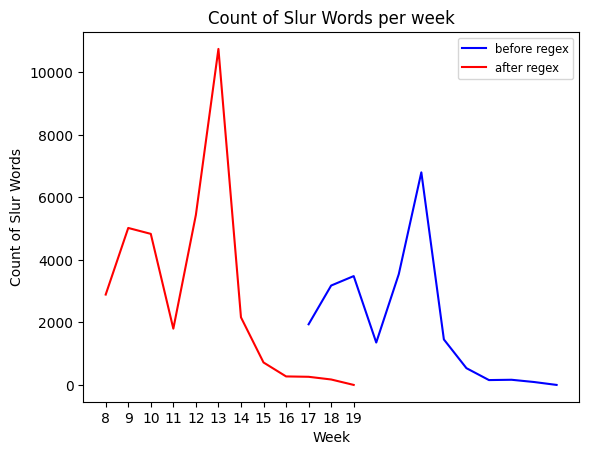

In [172]:
keys_before_regex = list(sorted_word_counts_beforeRegex_by_week.keys())[8:]
values_before_regex = list(sorted_word_counts_beforeRegex_by_week.values())[8:]

keys = np.arange(len(word_counts_afterRegex_by_week))
values = word_counts_afterRegex_by_week.tolist()

plt.plot(keys_before_regex, values_before_regex, color='blue', label='before regex')
plt.plot(keys[8:], values[8:], color='red', label='after regex')

plt.xlabel('Week')
plt.ylabel('Count of Slur Words')
plt.title('Count of Slur Words per week')
plt.xticks(keys[8:])
plt.legend(loc='best', fontsize='small')
plt.show()

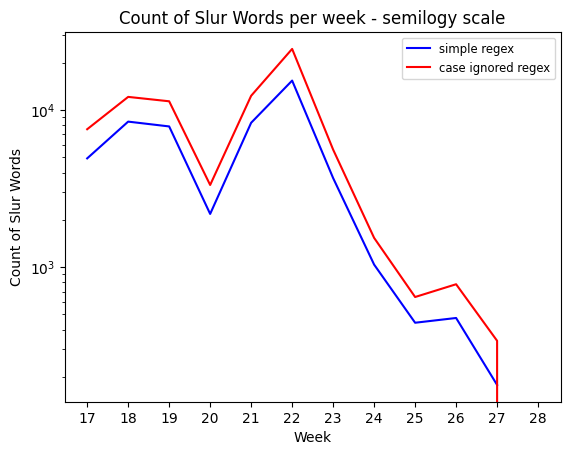

In [ ]:
plt.semilogy(slur_word_counts.index[1:], slur_word_counts.values[1:], color='blue', label='simple regex')
plt.semilogy(counts2.index[8:], counts2.values[8:], color='red', label='case ignored regex')
plt.xlabel('Week')
plt.ylabel('Count of Slur Words')
plt.title('Count of Slur Words per week - semilogy scale')
plt.xticks(counts2.index[8:])
plt.legend(loc='best', fontsize='small')
plt.show()

In [ ]:
# the pattern pretty much remains the same, only the count of slur words are increasing

In [ ]:
# Lets now look at the like counts accross the timeline of these hateful tweets.

In [ ]:
word_likes_per_week = {}

In [ ]:
timeDf['likeCount'] = timeDf['likeCount'].astype(int)

In [ ]:
from collections import defaultdict

In [ ]:
%%time
for index, row in timeDf.iterrows():
    text = row['textOriginal']
    week = row['week']
    like_count = row['likeCount']
    matches = compiled_pattern.findall(text)
    for word in matches:
        if week not in word_likes_per_week:
            word_likes_per_week[week] = 0
        word_likes_per_week[week] += like_count

CPU times: user 11min 13s, sys: 1.68 s, total: 11min 14s
Wall time: 11min 18s


In [ ]:
word_likes_per_week

{27: 27,
 26: 639,
 25: 89,
 24: 366,
 23: 2006,
 22: 13568,
 21: 3911,
 19: 2048,
 18: 4532,
 17: 4434,
 3: 629,
 20: 441,
 4: 24}

In [ ]:
x = sorted(word_likes_per_week.keys())
y = [word_likes_per_week[week] for week in x]

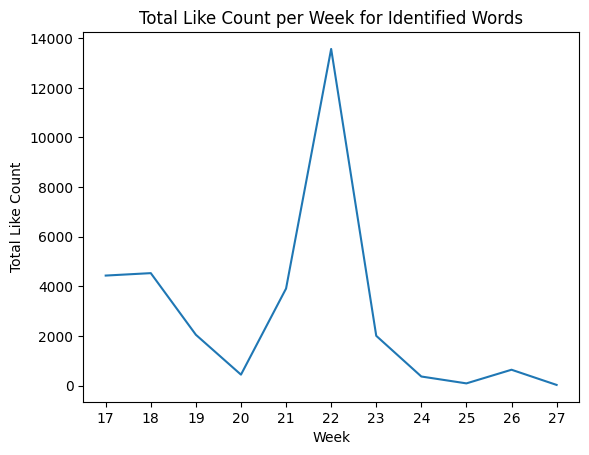

In [ ]:
plt.plot(x[2:], y[2:])
plt.xlabel('Week')
plt.ylabel('Total Like Count')
plt.title('Total Like Count per Week for Identified Words')
plt.xticks(x[2:])
plt.show()

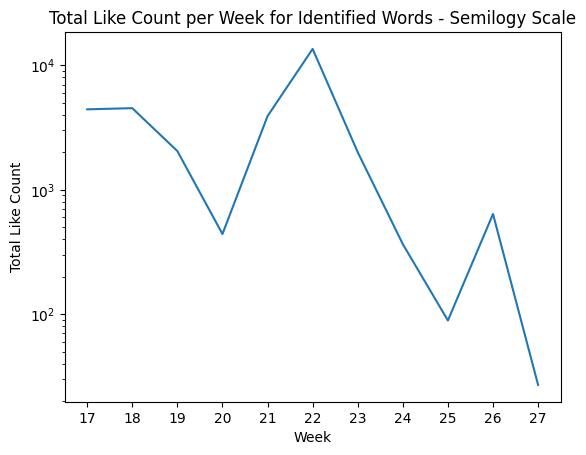

In [ ]:
plt.semilogy(x[2:], y[2:])
plt.xlabel('Week')
plt.ylabel('Total Like Count')
plt.title('Total Like Count per Week for Identified Words - Semilogy Scale')
plt.xticks(x[2:])
plt.show()

In [ ]:
# These plots could be showing these results because it could be also from the bias in dataset sampling.

In [ ]:
'''
check if these hateful tweets are replies or not too
'''

'\ncheck if these hateful tweets are replies or not too\n'

## Exisiting Lexicon Search
- Peach Teach Lab - Lexicons for detecting hate in african countries. - [Link](https://www.peacetechlab.org/hate-speech-lexicons)
- Hurtlex - Hateful words lexicon for many languages - [Link](https://github.com/valeriobasile/hurtlex)

## Identify Text Language

In [ ]:
# !pip install polyglot==16.7.4 > /dev/null 2>&1
# !pip install PyICU > /dev/null 2>&1
# !pip install pycld2 > /dev/null 2>&1

In [ ]:
# from polyglot.detect import Detector
# text = 'आप कैसे हैं?' text = 'તમે કેમ છો' text = 'எப்படி இருக்கிறீர்கள்' text = 'സുഖമാണോ' text = 'तू कसा आहेस'
# text_sample = 'आप कैसे हैं?'
# detector = Detector(text_sample)
# print(detector.language)
# print(detector.language.code)

## Uli Model

In [1]:
!pip install transformers > /dev/null 2>&1
!pip install --upgrade accelerate > /dev/null 2>&1

In [2]:
import torch
import torch.nn.functional as F
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

In [16]:
uliDf = df[['videoId','textOriginal','authorChannelId', 'likeCount', 'publishedAt', 'updatedAt', 'commentId']]

NameError: ignored

In [17]:
uliDf.shape

NameError: ignored

In [ ]:
header = np.array(uliDf.columns)
uliDf = uliDf[~np.all(uliDf.values == header, axis=1)]
uliDf = uliDf[~uliDf['videoId'].str.contains(r'\bvideoId\b', case=False, regex=True)]
pattern = r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z$'
uliDf = uliDf[uliDf['publishedAt'].str.contains(pattern)]

In [18]:
config = {
  "MODEL": "tattle-admin/july22-xlmtwtroberta-da-multi",
  "PRE_TRAINED_MODEL": "assets/model_state_dict.bin",
  "CLASS_NAMES": ["None", "Hate"],
  "MAX_SEQUENCE_LEN": 128
}

In [19]:
label_map= {
        0: 'None',
        1: 'Hate'
}

In [20]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
tokenizer = AutoTokenizer.from_pretrained(config['MODEL'])
classifier = AutoModelForSequenceClassification.from_pretrained(config['MODEL'])
classifier = classifier.to(device)

In [23]:
# classifier.load_state_dict(
#     torch.load(config["PRE_TRAINED_MODEL"], map_location=device)
# )

In [28]:
text = "yeh tu kya kar raha hai, fuck you and your job and your broke ass car"

In [29]:
encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
encoded_input.to(device)

{'input_ids': tensor([[    0, 76021,   370, 30427,  1185,  8980,  1337,     4, 40878,   398,
           136,   935, 12447,   136,   935,  7155,   350, 20751,  2258,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [30]:
output = classifier(**encoded_input)

In [31]:
with torch.no_grad():
    out = F.softmax(output[0].data, dim=-1).detach().cpu()
    out_label = torch.argmax(out,-1).numpy()
    print(f"{label_map[out_label[0]]}, {out[0][out_label].numpy()[0]}")

None, 0.5048973560333252


## nirantk/hinglish-bert

In [3]:
model_h = AutoModelForSequenceClassification.from_pretrained("nirantk/hinglish-bert")
tokenizer_h = AutoTokenizer.from_pretrained("nirantk/hinglish-bert")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nirantk/hinglish-bert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device_h = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
classifier_h = pipeline("sentiment-analysis", model=model_h, tokenizer = tokenizer_h, device=device_h)

In [13]:
text = "nikal yaha se madarchod"

In [14]:
res = classifier_h(text)

In [15]:
res

[{'label': 'LABEL_0', 'score': 0.5254068374633789}]

## Running the Seintiment Analysis Model

In [ ]:
import numpy as np
from scipy.special import softmax

In [ ]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

In [ ]:
# sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
# sentiment_task("I am very happy today")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
text = "Covid cases are increasing fast!"

In [ ]:
def apply_sentiment_analysis(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = np.exp(scores) / np.exp(scores).sum()
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    label = config.id2label[ranking[0]]
    score = scores[ranking[0]]
    return label, score

In [ ]:
label, score = apply_sentiment_analysis(text)
print(f"{label}, {score}")

negative, 0.7235763072967529


In [ ]:
sentimentDf = df[['videoId','textOriginal','authorChannelId', 'likeCount', 'publishedAt', 'updatedAt', 'commentId']]

In [ ]:
sentimentDf2 = sentimentDf.head(5000)

In [ ]:
sentimentDf2.shape

(5000, 7)

In [ ]:
sentimentDf2['label'] = ""
sentimentDf2['score'] = 0.0

<ipython-input-113-11ed32de50ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentimentDf2['label'] = ""
<ipython-input-113-11ed32de50ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentimentDf2['score'] = 0.0


In [ ]:
sentimentDf2.head()

,videoId,textOriginal,authorChannelId,likeCount,publishedAt,updatedAt,commentId,label,score
0,EBOKYsWUhvI,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,UgwbyvIkkAhUdaCFpcp4AaABAg,,0.0
1,EBOKYsWUhvI,Haar gye bechare,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,Ugyz3OwSXamho91-8I94AaABAg,,0.0
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,Ugyphs1TT1Yoj7MZBVJ4AaABAg,,0.0
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,UgwnIxpuFAcKsEzffBp4AaABAg,,0.0
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,UgxjuOlDigsmuDu53J54AaABAg,,0.0


In [ ]:
%%time
# for index, row in sentimentDf2.iterrows():
#     text = row['textOriginal']
#     label, score = apply_sentiment_analysis(text)
#     row['label'] = label
#     row['score'] = score

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
sentimentDf2.head()

,videoId,textOriginal,authorChannelId,likeCount,publishedAt,updatedAt,commentId,label,score
0,EBOKYsWUhvI,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,UgwbyvIkkAhUdaCFpcp4AaABAg,,0.0
1,EBOKYsWUhvI,Haar gye bechare,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,Ugyz3OwSXamho91-8I94AaABAg,,0.0
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,Ugyphs1TT1Yoj7MZBVJ4AaABAg,,0.0
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,UgwnIxpuFAcKsEzffBp4AaABAg,,0.0
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,UgxjuOlDigsmuDu53J54AaABAg,,0.0
